In [2]:
"""
NDVI (Normalized Difference Vegetation Index)
This most known and used vegetation index is a simple,
but effective VI for quantifying green vegetation.
It normalizes green leaf scattering in the Near Infra-red wavelength and chlorophyll absorption in the red wavelength.
Values description: The value range of an NDVI is -1 to 1. 
Negative values of NDVI (values approaching -1) correspond to water. 
Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. 
Low, positive values represent shrub and grassland (approximately 0.2 to 0.4), 
while high values indicate temperate and tropical rainforests (values approaching 1).
"""


"""
NDWI (Normalized Difference Water Index)
The NDWI index is most appropriate for water body mapping. 
The water body has strong absorbability and low radiation in the range from visible to infrared wavelengths. 
The index uses the green and Near Infra-red bands of remote sensing images based on this phenomenon. 
The NDWI can enhance the water information effectively in most cases. 
It is sensitive to built-up land and often results in over-estimated water bodies. 

Values description: Values of water bodies are larger than 0.5. 
Vegetation has much smaller values, which results in distinguishing vegetation from water bodies easier. 
Built-up features have positive values between zero and 0.2.
"""

# Look at other indices also, at https://www.sentinel-hub.com/develop/documentation/eo_products/Sentinel2EOproducts

#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask
import fiona
import pandas as pd
from helpers import return_indices
%matplotlib inline


In [3]:
# For testing also we need all of this
blue = rasterio.open('./All_Indices/S2_Mandya_B2.tif')
green = rasterio.open('./All_Indices/S2_Mandya_B3.tif')
red = rasterio.open('./All_Indices/S2_Mandya_B4.tif')
vre5 = rasterio.open('./All_Indices/S2_Mandya_B05.tif')
vre6 = rasterio.open('./All_Indices/S2_Mandya_B06.tif')
vre7 = rasterio.open('./All_Indices/S2_Mandya_B07.tif')
nir = rasterio.open('./All_Indices/S2_Mandya_B8.tif')
vre8a = rasterio.open('./All_Indices/S2_Mandya_B08A.tif')
swir11 = rasterio.open('./All_Indices/S2_Mandya_B11.tif')
swir12 = rasterio.open('./All_Indices/S2_Mandya_B12.tif')

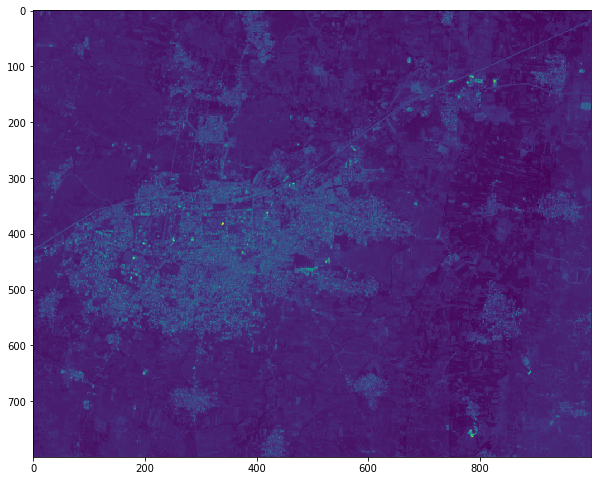

In [4]:
fig = plt.figure(figsize=(10,10))
img1 = blue.read(1)
plot.show(img1[5700:6500,6500:7500])

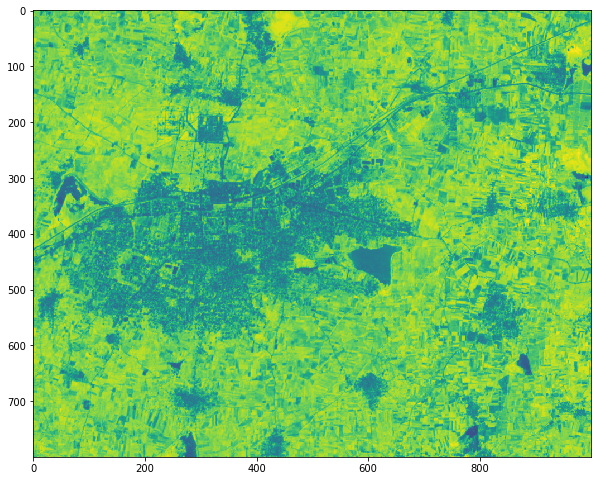

In [5]:
# ndvi from qgis
ndvi_8_4 = rasterio.open('./All_Indices/ndvi_8_4.tif')
fig = plt.figure(figsize=(10,10))
img = ndvi_8_4.read(1)
plot.show(img[5700:6500,6500:7500])

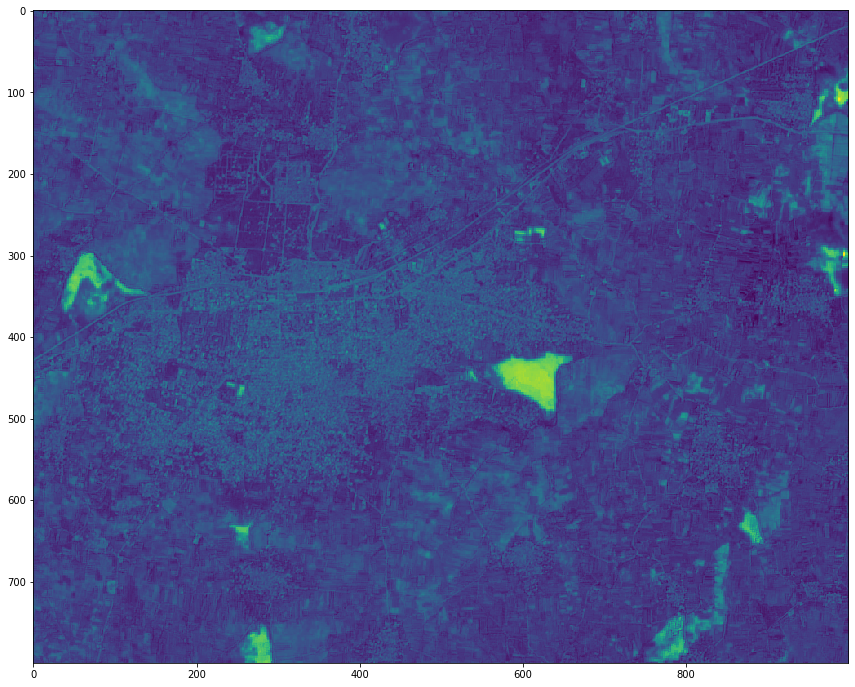

In [6]:
mndwi_4_11 = rasterio.open('./All_Indices/mndwi_4_11.tif')
fig = plt.figure(figsize=(18,12))
img = mndwi_4_11.read(1)
plot.show(img[5700:6500,6500:7500])

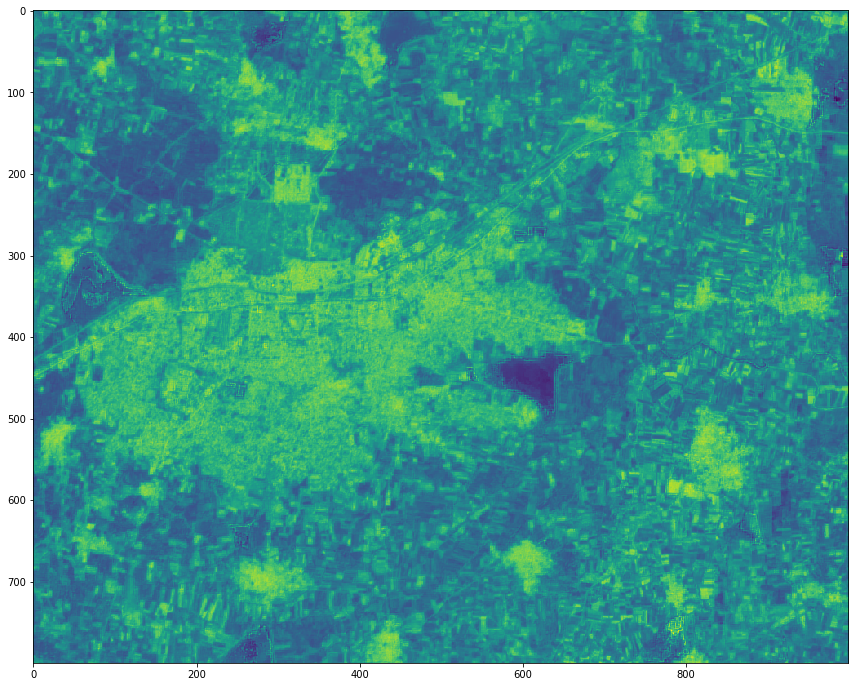

In [7]:
ndbi_11_8 = rasterio.open('.//All_Indices//ndbi_11_8.tif')
fig = plt.figure(figsize=(18,12))
img = ndbi_11_8.read(1)
plot.show(img[5700:6500,6500:7500])

In [25]:
# Final numpy array must be structured as follows
# Shape of array - [14, 10131, 12032]
# n - number of features / indices considered

# Features : [B02, B03, B04, B05, B06, B07, B8, B08A, B11, B12, ndvi, mndwi, ndbi]

In [59]:
feature_list = ["S2_Mandya_B2", "S2_Mandya_B3", "S2_Mandya_B4", "S2_Mandya_B05", "S2_Mandya_B06", 
                "S2_Mandya_B07", "S2_Mandya_B8", "S2_Mandya_B08A", "S2_Mandya_B11", "S2_Mandya_B12", 
                "ndvi_8_4", "mndwi_4_11", "ndbi_11_8"]
# "ndvi_8_4", "mndwi_4_11", "ndbi_11_8" will be added later in code
FOLDER = "./All_Indices/"

In [60]:
final_feature_array = []

In [61]:
# Indices are computed in helpers
for feature in feature_list[0:-3]:
    file = FOLDER + feature + ".tif"
    with rasterio.open(file) as src:
        image = src.read(1)
        final_feature_array.append(image[5700:6500,6500:7500])

In [62]:
ndvi, mndwi, ndbi = return_indices(final_feature_array)

In [63]:
final_feature_array.append(ndvi)
final_feature_array.append(mndwi)
final_feature_array.append(ndbi)

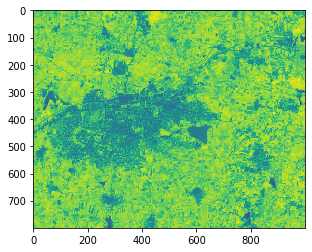

In [64]:
# ndvi from rasterio
plot.show(final_feature_array[-3])

In [65]:
final_features = np.array(final_feature_array)

In [66]:
# Normalize features to same scale before training

In [67]:
final_features.shape

(13, 800, 1000)

In [68]:
with fiona.open("C:\\Users\\anude\\Desktop\\MandyaV1\\rural\\rural.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [69]:
with rasterio.open("./All_Indices/ndbi_11_8.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=False)
    out_meta = src.meta
    
out_meta.update(
    {"driver": "GTiff",
     "height": out_image.shape[1],
     "width": out_image.shape[2],
     "transform": out_transform})

In [70]:
with rasterio.open("./target_tifs/masked_buildings_ndbi.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [71]:
out_image.shape

(1, 10131, 12032)

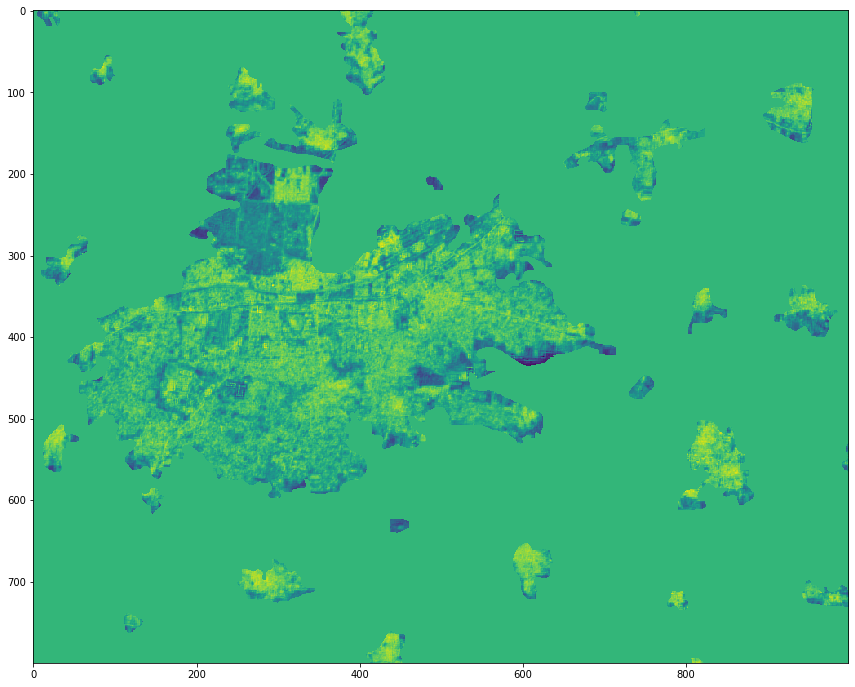

In [10]:
with rasterio.open('./target_tifs/masked_buildings_ndbi.tif') as water_mask:
    mandya_water_mask = water_mask.read(1)
fig = plt.figure(figsize=(18, 12))
plot.show(mandya_water_mask[5700:6500,6500:7500])

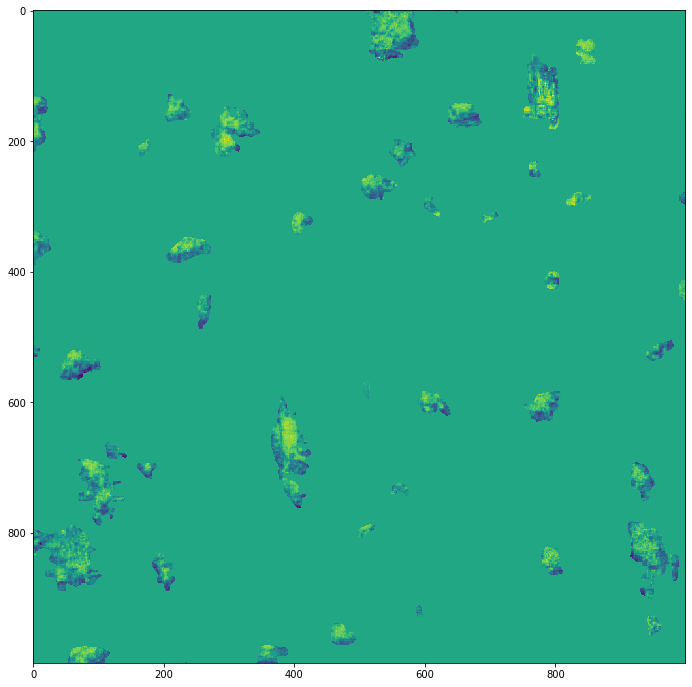

In [11]:
with rasterio.open('./target_tifs/masked_buildings_ndbi.tif') as water_mask:
    mandya_water_mask = water_mask.read(1)
fig = plt.figure(figsize=(18, 12))
plot.show(mandya_water_mask[4000:5000,7000:8000])

In [73]:
with fiona.open("./shpfiles/correct_distshapefile.shp", "r") as shapefile:
    shapes_dist = [feature["geometry"] for feature in shapefile]

In [74]:
with rasterio.open("./All_Indices/mndwi_4_11.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes_dist, crop=False)
    out_meta = src.meta
    
out_meta.update(
    {"driver": "GTiff", 
     "height": out_image.shape[1], 
     "width": out_image.shape[2],
     "transform": out_transform})

In [75]:
out_image[0].shape

(10131, 12032)

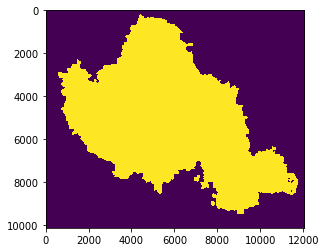

In [76]:
plot.show(out_image[3])

In [77]:
with rasterio.open("./target_tifs/masked_dist.tif", "w", **out_meta) as dest:
    dest.write(out_image)

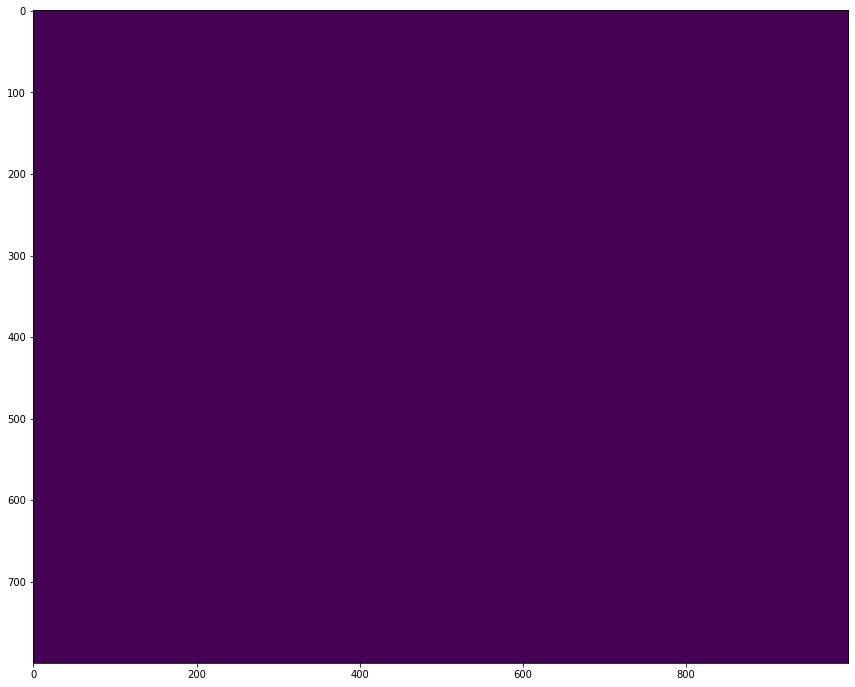

In [78]:
with rasterio.open('./target_tifs/masked_dist.tif') as dist_mask:
    mandya_dist_mask = dist_mask.read(4)

fig = plt.figure(figsize=(18, 12))
plot.show(mandya_dist_mask[5700:6500,6500:7500])

### Data Pre-processing

In [79]:
final_features = np.array(final_feature_array) # Each training example (so reshape into (12032*10131, 14))
final_features[:,0,0]

array([ 0.0955    ,  0.0955    ,  0.0734    ,  0.1123    ,  0.22095   ,
        0.2621    ,  0.261     ,  0.28435   ,  0.19305   ,  0.0895    ,
        0.56100478, -0.44905236, -0.14965312])

In [80]:
final_features.shape

(13, 800, 1000)

In [81]:
for i in range(len(final_features)):
    print(feature_list[i], "=", final_features[i].min(), final_features[i].max())

S2_Mandya_B2 = 0.0781 0.34515
S2_Mandya_B3 = 0.066 0.3589
S2_Mandya_B4 = 0.0427 0.39175
S2_Mandya_B05 = 0.0521 0.34005
S2_Mandya_B06 = 0.055 0.3885
S2_Mandya_B07 = 0.0625 0.49375
S2_Mandya_B8 = 0.0549 0.49125
S2_Mandya_B08A = 0.0529 0.5316
S2_Mandya_B11 = 0.02125 0.5101
S2_Mandya_B12 = 0.01105 0.5332
ndvi_8_4 = -0.32004381161007667 0.7995642701525054
mndwi_4_11 = -0.6332651670074984 0.6702203269367448
ndbi_11_8 = -0.7397971803116499 0.37538597265108076


In [82]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

In [83]:
normalized_features = []

In [84]:
for i in range(len(final_feature_array)):
    print(i)
    normalized_features.append(normalize(final_feature_array[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12


In [85]:
normalized_features = np.array(normalized_features)
normalized_features.shape

(13, 800, 1000)

In [86]:
shp = normalized_features.shape
pd.DataFrame(normalized_features.reshape((shp[0], shp[1]*shp[2])))

0         1         2         3         4         5         6       \
0   0.065156  0.076952  0.082943  0.084067  0.088186  0.091930  0.076390   
1   0.100717  0.088767  0.078696  0.080232  0.087060  0.086719  0.082622   
2   0.087953  0.070477  0.060450  0.058015  0.054433  0.057871  0.055006   
3   0.209064  0.163917  0.163917  0.122417  0.122417  0.136135  0.136135   
4   0.497601  0.392504  0.392504  0.378861  0.378861  0.431484  0.431484   
5   0.462841  0.420870  0.420870  0.392348  0.392348  0.423884  0.423884   
6   0.472327  0.380314  0.343188  0.326344  0.362782  0.373324  0.418815   
7   0.483497  0.444119  0.444119  0.412994  0.412994  0.461145  0.461145   
8   0.351437  0.232996  0.232996  0.191163  0.191163  0.241690  0.241690   
9   0.150244  0.113760  0.113760  0.079575  0.079575  0.104472  0.104472   
10  0.786926  0.761808  0.754481  0.746938  0.778088  0.778735  0.809888   
11  0.141323  0.228710  0.210691  0.262344  0.255324  0.195717  0.190464   
12  0.529190  0.447520  0.479980  0.425987  0.394017  0.466571  0.429725   

      7         8         9       ...    799990    799991    799992    799993  \
0   0.097173  0.111215  0.121887  ...  0.114960  0.115334  0.119453  0.116832   
1   0.098498  0.139809  0.141174  ...  0.148515  0.143735  0.136224  0.124957   
2   0.067612  0.134794  0.203839  ...  0.083656  0.086234  0.085948  0.083942   
3   0.216010  0.216010  0.283730  ...  0.195173  0.210106  0.210106  0.180240   
4   0.482909  0.482909  0.486807  ...  0.630285  0.641379  0.641379  0.609595   
5   0.450551  0.450551  0.456928  ...  0.637913  0.631652  0.631652  0.615420   
6   0.452389  0.466140  0.464535  ...  0.596769  0.568809  0.561476  0.559642   
7   0.475663  0.475663  0.484124  ...  0.648214  0.623982  0.623982  0.612074   
8   0.357778  0.357778  0.405441  ...  0.293648  0.307763  0.307763  0.294467   
9   0.195538  0.195538  0.254046  ...  0.128603  0.134540  0.134540  0.125539   
10  0.807290  0.718388  0.631507  ...  0.847314  0.833065  0.830481  0.832442   
11  0.106257  0.200315  0.242759  ...  0.184724  0.175503  0.175063  0.184389   
12  0.551110  0.540753  0.591675  ...  0.382288  0.415222  0.419623  0.404782   

      799994    799995    799996    799997    799998    799999  
0   0.112339  0.106722  0.110092  0.112713  0.110466  0.116458  
1   0.109594  0.107887  0.113008  0.116422  0.116763  0.117788  
2   0.077639  0.068472  0.068185  0.067899  0.069618  0.071623  
3   0.180240  0.153846  0.153846  0.145859  0.145859  0.150721  
4   0.609595  0.597001  0.597001  0.595502  0.595502  0.624888  
5   0.615420  0.621913  0.621913  0.623768  0.623768  0.663652  
6   0.556663  0.579581  0.609832  0.596310  0.576601  0.596998  
7   0.612074  0.627951  0.627951  0.626697  0.626697  0.656152  
8   0.294467  0.276261  0.276261  0.272374  0.272374  0.271965  
9   0.125539  0.110409  0.110409  0.108877  0.108877  0.107728  
10  0.839832  0.861261  0.872464  0.868111  0.858582  0.863348  
11  0.174385  0.177096  0.176613  0.180067  0.182974  0.186768  
12  0.406574  0.370665  0.353961  0.356460  0.367465  0.355571  

[13 rows x 800000 columns]

In [87]:
normalized_features = normalized_features.reshape((shp[0], shp[1]*shp[2]))

In [88]:
normalized_features.shape

(13, 800000)

In [89]:
# pd.DataFrame(normalized_features.T).to_csv("./Understanding the Data/reshaped_norm_features.csv")

In [90]:
normalized_features = normalized_features.T

In [91]:
# Train data is done
# Target must be obtained (0/1)
mandya_dist_mask = mandya_dist_mask[5700:6500,6500:7500]
mandya_water_mask = mandya_water_mask[5700:6500,6500:7500]

In [92]:
mandya_dist_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [93]:
normalized_features.shape

(800000, 13)

In [94]:
# 1. Map pixel numbers to x,y coordinates of image
# 2. Choose only those pixels that are inside the mandya region
# 3. Choose target as 1 if pixel number in both masks is non-zero
# mandya_dist_mask, mandya_water_mask
pixel_positions = []
in_mandya_features = []
target_values = []
dim = mandya_dist_mask.shape
for i in range(dim[0]):
    for j in range(dim[1]):
        if(mandya_dist_mask[i,j]!=0):
            in_mandya_features.append(normalized_features[i*dim[0]+j])
            pixel_positions.append((i,j))
            if(mandya_water_mask[i,j]!=0):
                target_values.append(1)
            else:
                target_values.append(0)
            if(i%1000==0 or j%1000==0):
                print((i*dim[0]+j, i, j))

(0, 0, 0)
(1, 0, 1)
(2, 0, 2)
(3, 0, 3)
(4, 0, 4)
(5, 0, 5)
(6, 0, 6)
(7, 0, 7)
(8, 0, 8)
(9, 0, 9)
(10, 0, 10)
(11, 0, 11)
(12, 0, 12)
(13, 0, 13)
(14, 0, 14)
(15, 0, 15)
(16, 0, 16)
(17, 0, 17)
(18, 0, 18)
(19, 0, 19)
(20, 0, 20)
(21, 0, 21)
(22, 0, 22)
(23, 0, 23)
(24, 0, 24)
(25, 0, 25)
(26, 0, 26)
(27, 0, 27)
(28, 0, 28)
(29, 0, 29)
(30, 0, 30)
(31, 0, 31)
(32, 0, 32)
(33, 0, 33)
(34, 0, 34)
(35, 0, 35)
(36, 0, 36)
(37, 0, 37)
(38, 0, 38)
(39, 0, 39)
(40, 0, 40)
(41, 0, 41)
(42, 0, 42)
(43, 0, 43)
(44, 0, 44)
(45, 0, 45)
(46, 0, 46)
(47, 0, 47)
(48, 0, 48)
(49, 0, 49)
(50, 0, 50)
(51, 0, 51)
(52, 0, 52)
(53, 0, 53)
(54, 0, 54)
(55, 0, 55)
(56, 0, 56)
(57, 0, 57)
(58, 0, 58)
(59, 0, 59)
(60, 0, 60)
(61, 0, 61)
(62, 0, 62)
(63, 0, 63)
(64, 0, 64)
(65, 0, 65)
(66, 0, 66)
(67, 0, 67)
(68, 0, 68)
(69, 0, 69)
(70, 0, 70)
(71, 0, 71)
(72, 0, 72)
(73, 0, 73)
(74, 0, 74)
(75, 0, 75)
(76, 0, 76)
(77, 0, 77)
(78, 0, 78)
(79, 0, 79)
(80, 0, 80)
(81, 0, 81)
(82, 0, 82)
(83, 0, 83)
(84, 0, 84)


(91200, 114, 0)
(92000, 115, 0)
(92800, 116, 0)
(93600, 117, 0)
(94400, 118, 0)
(95200, 119, 0)
(96000, 120, 0)
(96800, 121, 0)
(97600, 122, 0)
(98400, 123, 0)
(99200, 124, 0)
(100000, 125, 0)
(100800, 126, 0)
(101600, 127, 0)
(102400, 128, 0)
(103200, 129, 0)
(104000, 130, 0)
(104800, 131, 0)
(105600, 132, 0)
(106400, 133, 0)
(107200, 134, 0)
(108000, 135, 0)
(108800, 136, 0)
(109600, 137, 0)
(110400, 138, 0)
(111200, 139, 0)
(112000, 140, 0)
(112800, 141, 0)
(113600, 142, 0)
(114400, 143, 0)
(115200, 144, 0)
(116000, 145, 0)
(116800, 146, 0)
(117600, 147, 0)
(118400, 148, 0)
(119200, 149, 0)
(120000, 150, 0)
(120800, 151, 0)
(121600, 152, 0)
(122400, 153, 0)
(123200, 154, 0)
(124000, 155, 0)
(124800, 156, 0)
(125600, 157, 0)
(126400, 158, 0)
(127200, 159, 0)
(128000, 160, 0)
(128800, 161, 0)
(129600, 162, 0)
(130400, 163, 0)
(131200, 164, 0)
(132000, 165, 0)
(132800, 166, 0)
(133600, 167, 0)
(134400, 168, 0)
(135200, 169, 0)
(136000, 170, 0)
(136800, 171, 0)
(137600, 172, 0)
(138400,

(539200, 674, 0)
(540000, 675, 0)
(540800, 676, 0)
(541600, 677, 0)
(542400, 678, 0)
(543200, 679, 0)
(544000, 680, 0)
(544800, 681, 0)
(545600, 682, 0)
(546400, 683, 0)
(547200, 684, 0)
(548000, 685, 0)
(548800, 686, 0)
(549600, 687, 0)
(550400, 688, 0)
(551200, 689, 0)
(552000, 690, 0)
(552800, 691, 0)
(553600, 692, 0)
(554400, 693, 0)
(555200, 694, 0)
(556000, 695, 0)
(556800, 696, 0)
(557600, 697, 0)
(558400, 698, 0)
(559200, 699, 0)
(560000, 700, 0)
(560800, 701, 0)
(561600, 702, 0)
(562400, 703, 0)
(563200, 704, 0)
(564000, 705, 0)
(564800, 706, 0)
(565600, 707, 0)
(566400, 708, 0)
(567200, 709, 0)
(568000, 710, 0)
(568800, 711, 0)
(569600, 712, 0)
(570400, 713, 0)
(571200, 714, 0)
(572000, 715, 0)
(572800, 716, 0)
(573600, 717, 0)
(574400, 718, 0)
(575200, 719, 0)
(576000, 720, 0)
(576800, 721, 0)
(577600, 722, 0)
(578400, 723, 0)
(579200, 724, 0)
(580000, 725, 0)
(580800, 726, 0)
(581600, 727, 0)
(582400, 728, 0)
(583200, 729, 0)
(584000, 730, 0)
(584800, 731, 0)
(585600, 732, 

In [97]:
len(pixel_positions)

800000

In [98]:
print((750, 1000) in pixel_positions) # Check pixel coordinates in ndvi / mndwi image
index = pixel_positions.index((750, 1000))
print(index)
print(in_mandya_features[index])
print(target_values[index])

False


ValueError: (750, 1000) is not in list

In [99]:
# arr = range(0, len(in_mandya_features), 500000)
# for i in arr[10:]:
#     if(i==arr[-1]):
#         X_train = pd.DataFrame(in_mandya_features[i:])
#         X_train["target"] = target_values[i:]
#         X_train.to_csv("./Train Data/Train_data_"+str(i)+"_"+str(len(in_mandya_features))+".csv")
#     else:
#         X_train = pd.DataFrame(in_mandya_features[i:i+500000])
#         X_train["target"] = target_values[i:i+500000]
#         X_train.to_csv("./Train Data/Train_data_"+str(i)+"_"+str(i+500000)+".csv")

In [100]:
X_train = pd.DataFrame(in_mandya_features)
X_train["target"] = target_values
X_train["pixel_positions"] = pixel_positions

In [101]:
X_train
#X_train.to_csv("./Small_Train_data.csv")

0         1         2         3         4         5         6  \
0       0.065156  0.100717  0.087953  0.209064  0.497601  0.462841  0.472327   
1       0.076952  0.088767  0.070477  0.163917  0.392504  0.420870  0.380314   
2       0.082943  0.078696  0.060450  0.163917  0.392504  0.420870  0.343188   
3       0.084067  0.080232  0.058015  0.122417  0.378861  0.392348  0.326344   
4       0.088186  0.087060  0.054433  0.122417  0.378861  0.392348  0.362782   
...          ...       ...       ...       ...       ...       ...       ...   
799995  0.104849  0.104302  0.083083  0.154367  0.434183  0.441391  0.406211   
799996  0.101666  0.105838  0.083083  0.154367  0.434183  0.441391  0.426034   
799997  0.103539  0.106521  0.104713  0.181976  0.457421  0.457159  0.421107   
799998  0.112526  0.123250  0.138232  0.181976  0.457421  0.457159  0.412971   
799999  0.133683  0.144589  0.132216  0.199514  0.457571  0.489623  0.433024   

               7         8         9        10        11        12  target  \
0       0.483497  0.351437  0.150244  0.786926  0.141323  0.529190       0   
1       0.444119  0.232996  0.113760  0.761808  0.228710  0.447520       0   
2       0.444119  0.232996  0.113760  0.754481  0.210691  0.479980       0   
3       0.412994  0.191163  0.079575  0.746938  0.262344  0.425987       0   
4       0.412994  0.191163  0.079575  0.778088  0.255324  0.394017       0   
...          ...       ...       ...       ...       ...       ...     ...   
799995  0.447880  0.266953  0.139711  0.757498  0.210988  0.475588       0   
799996  0.447880  0.266953  0.139711  0.769165  0.210988  0.459967       0   
799997  0.471381  0.255088  0.151298  0.733703  0.258602  0.447252       0   
799998  0.471381  0.255088  0.151298  0.680733  0.307713  0.453592       0   
799999  0.515145  0.269612  0.135306  0.701968  0.282217  0.458242       0   

       pixel_positions  
0               (0, 0)  
1               (0, 1)  
2               (0, 2)  
3               (0, 3)  
4               (0, 4)  
...                ...  
799995      (799, 995)  
799996      (799, 996)  
799997      (799, 997)  
799998      (799, 998)  
799999      (799, 999)  

[800000 rows x 15 columns]

In [103]:
x_small = X_train[X_train[11] >= 0.5]
x_small[x_small["target"]==1]

0         1         2         3         4         5         6  \
127369  0.077139  0.077501  0.047558  0.085779  0.271964  0.243942  0.221611   
127373  0.062910  0.057016  0.042401  0.071193  0.210195  0.189681  0.134983   
132367  0.076390  0.047115  0.030941  0.026046  0.082759  0.059362  0.047668   
132368  0.079386  0.053602  0.030941  0.026046  0.082759  0.059362  0.043543   
132369  0.077888  0.047456  0.028649  0.018406  0.065967  0.049159  0.043314   
...          ...       ...       ...       ...       ...       ...       ...   
791448  0.082943  0.073745  0.060020  0.063205  0.071214  0.058319  0.037012   
791449  0.080135  0.074087  0.062885  0.055739  0.061919  0.050435  0.040105   
796449  0.080884  0.074087  0.060307  0.070151  0.100300  0.083594  0.048699   
796450  0.079011  0.073745  0.060593  0.070151  0.100300  0.083594  0.045033   
796451  0.080509  0.072038  0.059017  0.059212  0.069565  0.049507  0.037585   

               7         8         9        10        11        12  target  \
127369  0.221433  0.071699  0.033420  0.676748  0.505734  0.252339       1   
127373  0.201170  0.068221  0.029589  0.579405  0.505671  0.348152       1   
132367  0.053896  0.012581  0.010246  0.439324  0.733331  0.243296       1   
132368  0.053896  0.012581  0.010246  0.428873  0.733331  0.251765       1   
132369  0.051598  0.014217  0.008905  0.434833  0.718158  0.262502       1   
...          ...       ...       ...       ...       ...       ...     ...   
791448  0.071026  0.054311  0.023652  0.334921  0.594929  0.487967       1   
791449  0.059118  0.025161  0.011970  0.336361  0.728789  0.334577       1   
796449  0.085022  0.053288  0.030930  0.365019  0.599467  0.453826       1   
796450  0.085022  0.053288  0.030930  0.354906  0.600055  0.462849       1   
796451  0.060581  0.045106  0.016566  0.338939  0.629760  0.444294       1   

       pixel_positions  
127369      (127, 369)  
127373      (127, 373)  
132367      (132, 367)  
132368      (132, 368)  
132369      (132, 369)  
...                ...  
791448      (791, 448)  
791449      (791, 449)  
796449      (796, 449)  
796450      (796, 450)  
796451      (796, 451)  

[3142 rows x 15 columns]

In [104]:
X_train.to_csv("./final_data_building.csv")

In [1]:
fig = plt.figure(figsize=(10,10))
img1 = blue.read(1)
plot.show(img1[5700:6500,6500:7500])

NameError: name 'plt' is not defined

In [ ]:
with rasterio.open('./target_tifs/masked_buildings_ndbi.tif') as water_mask:
    mandya_water_mask = water_mask.read(1)
fig = plt.figure(figsize=(18, 12))
plot.show(mandya_water_mask[5700:6500,6500:7500])